# Principal Coordinate Analysis

## Introduction

In this notebook we will recreate Panels B and C from Figure 1 of the [Pf7 Paper](https://wellcomeopenresearch.org/articles/8-22/v1).

Both panels contain a **Principal Coordinate Analysis** used to identify patterns of geographic and genetic structure within the dataset.

**This notebook should take approximately 15 minutes to run**

### **Principal Coordinate Analysis - PCoA**
PCoA falls into a category of analyses which focus on "*dimensionality reduction*". Dimensionality reduction is used in data analysis to simplify complex data by reducing the number of variables while still retaining meaningful properties from the original dataset.

The PCoA we will calculate is based on a large distance matrix of pairwise genetic distances between 16,203 *Plasmodium falciparum* samples. The distances were generated using high-quality, bi-allelic coding single nucleotide polymorphisms (SNPs) from throughout the Pf genome.

The PCoA seeks to represent these pairwise distances in a lower-dimensional space, while preserving their relative distances as accurately as possible.

Thus, we can simply view relative genetic distances between samples from different geographical locations.

## Setup

Install the MalariaGEN data package:

In [1]:
!pip install -q --no-warn-conflicts malariagen_data

Install another required package, scikit-bio:

In [2]:
!pip install -q --no-warn-conflicts scikit-bio

Load the required Python libraries:

In [3]:
import malariagen_data
from ftplib import FTP
import scipy.stats
import scipy.spatial.distance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import skbio
from skbio.stats.ordination import pcoa
from google.colab import drive

## Data Access

First load the Pf7 metadata:


In [4]:
# Load Pf7 data
release_data = malariagen_data.Pf7()
sample_metadata = release_data.sample_metadata()
sample_metadata.head(3) # View the data

Sample              Study     Country   Admin level 1  Country latitude  \
0   FP0008-C  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
1   FP0009-C  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
2  FP0010-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   

   Country longitude  Admin level 1 latitude  Admin level 1 longitude    Year  \
0         -10.337093               16.565426                -9.832345  2014.0   
1         -10.337093               16.565426                -9.832345  2014.0   
2         -10.337093               16.565426                -9.832345  2014.0   

          ENA All samples same case Population  % callable  QC pass  \
0  ERR1081237              FP0008-C       AF-W       82.16     True   
1  ERR1081238              FP0009-C       AF-W       88.85     True   
2  ERR2889621             FP0010-CW       AF-W       86.46     True   

  Exclusion reason Sample type  Sample was in Pf6  
0     Analysis_set        gDNA               True  
1     Analysis_set        gDNA               True  
2     Analysis_set        sWGA              False

In [5]:
# Notice we have data for all 20,864 samples
sample_metadata.shape

(20864, 17)

We then need to load the distance matrix, which is available from a FTP (file transfer protocol) server. We log in to this server and make a copy of the distance matrix in our Google Colab space.

In [6]:
# Load the distance matrix
# Replace these values with your FTP server details
ftp_host = 'ngs.sanger.ac.uk'
ftp_file_path = '/production/malaria/Resource/34/Pf7_genetic_distance_matrix.npy'

# Create an FTP instance and connect to the server
ftp = FTP(ftp_host)
ftp.login()

# Change the current directory to the location of the file
ftp.cwd('/production/malaria/Resource/34/')  # Change to the root directory or your desired directory

# Download the file to Colab
with open('Pf7_genetic_distance_matrix.npy', 'wb') as file:
    ftp.retrbinary('RETR ' + ftp_file_path, file.write)

# Close the FTP connection
ftp.quit()

# Check if the file is downloaded successfully
import os
if os.path.exists('Pf7_genetic_distance_matrix.npy'):
    print('File downloaded successfully.')
else:
    print('File download failed.')

File downloaded successfully.


In [7]:
distance_matrix_fn = 'Pf7_genetic_distance_matrix.npy'
mean_distance_matrix = np.load(distance_matrix_fn)
mean_distance_matrix.shape # Also contains data for 20,864 samples

(20864, 20864)

## Subset data

We want to make sure we can rely on our results. To give the best chance of this, we select only samples which passed quality control (QC) filters.

We need to subset the sample_metadata dataframe and the distance matrix so they only contain these samples.

In [8]:
# Subset the metadata using the 'QC pass' column
# Select only rows where the value is 'True'
sample_metadata_qc_pass = sample_metadata[sample_metadata['QC pass'] == True]
sample_metadata_qc_pass.shape

(16203, 17)

We now have 16,203 samples in this dataframe.

In [9]:
# Subset the distance matrix using the same column
mean_distance_matrix_qc_pass = mean_distance_matrix[sample_metadata['QC pass'].values][:, sample_metadata['QC pass'].values]
mean_distance_matrix_qc_pass.shape

(16203, 16203)

And we have 16,203 samples in the distance matrix.

## Perform PCoA

Now we will perform the dimensionality reduction to pull out the most important components of variation in the dataset.

In [10]:
# The diagonal of the matrix, where each sample is compared to itself,
# must be manually set to zero to avoid an error from pcoa
mean_distance_matrix_qc_pass_hollow = mean_distance_matrix_qc_pass.copy()
np.fill_diagonal(mean_distance_matrix_qc_pass_hollow, 0)

In [11]:
# This will produce the underlying values for the figure
# This may take ~ 10 minutes to run
pcoa_results = pcoa(mean_distance_matrix_qc_pass_hollow)

/usr/local/lib/python3.10/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.00041146459989249706 and the largest is 0.004861593246459961.
  warn(


In [12]:
# Make sure the results are the size we expect (16,203)
pcoa_results.samples.shape

(16203, 16203)

Now dimensionality reduction has been applied, we are given a list of **Principal Coordinates (PC)** and information on the proportion of total data variation explained by each PC.

In [13]:
# View proportion of variation explained by each PC
pcoa_results.proportion_explained*100

PC1        17.578421
PC2         2.361353
PC3         0.773960
PC4         0.739100
PC5         0.668693
             ...    
PC16199     0.000000
PC16200     0.000000
PC16201     0.000000
PC16202     0.000000
PC16203     0.000000
Length: 16203, dtype: float32

**The most useful PCs for explaining sample similarity/dissimilarity are those which explain most of the variation**

You can see that the 1st PC, **PC1**, explains the most variation, at around 17.5% of the total variation.

**PC2** explains 7.5x less variation, at around 2%.

**PC3** explains even less, at 0.7%.

Eventually the PCs become useless, explaining 0% of variation.


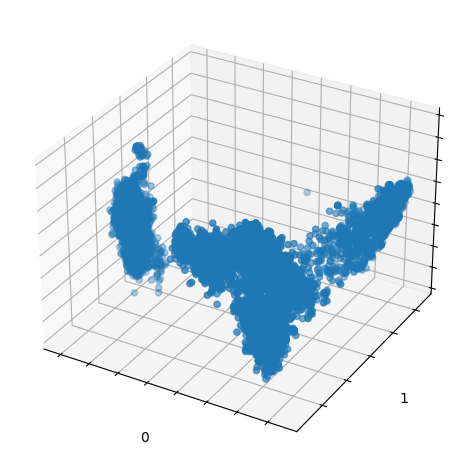

In [14]:
# View a preliminary PCoA plot from these results
# This plot shows sample relatedness along three PCs: PC1,PC2,PC3
pcoa_results

It looks like there might be distinct clusters of samples emerging along the first three PCs. At the moment, we can't say more than that because we have not assigned any information to the points (samples) in the plot.

We want to know whether samples show geographical genetic structure, so we need to give each major sub-population a distinguishing factor. In this case, we will use different colours for each sub-population.

## Assign colours to sub-populations



In [15]:
# View subpopulations in dataset
sample_metadata_qc_pass['Population'].value_counts()

AF-W       6261
AS-SE-E    3721
AS-SE-W    1880
AF-E       1539
AS-S-FE    1377
AF-C        520
OC-NG       342
AS-S-E      233
AF-NE       172
SA          158
Name: Population, dtype: int64

We will use an ordered dictionary to assign colours (designated with a HEX code) to major sub-populations.

Use of an ordered dictionary, rather than a regular dictionary, allows us to keep sub-populations in order from west to east. This is the way these sub-populations are ordered throughout Pf7 material.

In [16]:
# Define ordered dictionary to map colours to sub-populations
colourings = collections.OrderedDict()
colourings['Population'] = collections.OrderedDict()

# We nest a regular dictionary within the ordered dictionary which contains the
# colour-subpopulation associations
population_colours = {}
population_colours['SA']     = "#4daf4a"
population_colours['AF-W']= "#e31a1c"
population_colours['AF-C'] = "#fd8d3c"
population_colours['AF-NE'] = "#bb8129"
population_colours['AF-E'] = "#fecc5c"
population_colours['AS-S-E'] = "#dfc0eb"
population_colours['AS-S-FE'] = "#984ea3"
population_colours['AS-SE-W'] = "#9ecae1"
population_colours['AS-SE-E'] = "#3182bd"
population_colours['OC-NG'] = "#f781bf"

# Assign the population_colours dictionary to the 'Population' key within the colourings ordered dictionary.
colourings['Population'] = population_colours

In [17]:
# Check all associations are as expected
colourings['Population']

{'SA': '#4daf4a',
 'AF-W': '#e31a1c',
 'AF-C': '#fd8d3c',
 'AF-NE': '#bb8129',
 'AF-E': '#fecc5c',
 'AS-S-E': '#dfc0eb',
 'AS-S-FE': '#984ea3',
 'AS-SE-W': '#9ecae1',
 'AS-SE-E': '#3182bd',
 'OC-NG': '#f781bf'}

## Plot the PCoA

We will define two functions that will build the PCoA plot:

**1. plot_pca_coords**: This function takes the pcoa results and the sample metadata as input, while also having several other parameters to customise the plot appearance.

An important parameter to note is `sample_populations`. The ordering of populations in the plot determines the order that points are layered on the plot. So if Central Africa is plotted before the larger, closely related populations of West Africa and East Africa, then Central Africa becomes covered by the larger populations' points. This parameter lets us tweak the order of populations so that plot clarity is enhanced.  

In [18]:
# Define the function and its input parameters
def plot_pca_coords(pcoa_results, pc1, pc2, ax, df_samples=sample_metadata_qc_pass,
                    sample_populations=None,
                    population_column='Population',
                    xlim=None, ylim=None,
                    include_n_in_legend=False,
                    include_prop_explain=False,
                    is_label_sample=False,
                    legend_loc=None,
                    bbox_to_anchor=None,
                    is_randomize=False,
                    legend_order=None
                   ):

    # A note on ordering populations
    """
    Parameters:
     - sample_populations: array-like (str)
         populations to display.
         If target_populations is None, then displays all populations in the order they appear
         in the df_samples DataFrame
    - legend_order:  array-like (str)
        order of populations in the legend.  If None, and sample_populations is None,
        then uses the order they appear in df_samples.
        If None and sample_populations is filled, then uses the order in sample_populations.
    """
    # Remove the upper and right-hand borders from the plot to ensure points are not obscured
    sns.despine(ax=ax, offset=5)

    # Determine which population ordering to use
    if sample_populations is None:
        target_populations = df_samples[population_column].unique()
    else:
        target_populations = sample_populations

    # This condition deals with randomising the plotting of population points
    # If the parameter is set to 'True' then points are plotted randomly
    # If it is set to 'False' then populations are plotted in order.
    if is_randomize:

        # Filter samples according to the target populations
        df_samples_filt = df_samples.loc[df_samples[population_column].isin(target_populations),
                                    [population_column]].copy()

        # Select and apply their corresponding subpopulation colour
        colourings_df = pd.DataFrame.from_dict(colourings[population_column], orient="index", columns=["color"])
        colourings_df.index.rename(population_column, inplace=True)
        colourings_df = colourings_df.reset_index(drop=False)
        df_samples_filt = df_samples_filt.merge(colourings_df, how="left",
                                                left_on=population_column,
                                               right_on=population_column)

        # Select corresponding values from pcoa results
        filt = np.isin(df_samples[population_column].values, target_populations)
        x_filt = pcoa_results.samples.loc[filt, pc1]
        y_filt = pcoa_results.samples.loc[filt, pc2]
        color = df_samples_filt["color"].values

        # Randomly reorder the data points using a permutation of indices.
        plot_idx = np.random.permutation(df_samples_filt.shape[0])
        x_filt = x_filt[plot_idx]
        y_filt = y_filt[plot_idx]
        color = color[plot_idx]

        # Finally, scatter plot the randomized data points onto the plot
        ax.scatter(
            x_filt,
            y_filt,
            marker='o',
            color=color,
            s=30,
            edgecolor='k',
            linewidths=.5,
        )

    else:
        # Plot each population in order
        for target_popn in target_populations:
            x_filt = pcoa_results.samples.loc[df_samples[population_column].values == target_popn, pc1]
            y_filt = pcoa_results.samples.loc[df_samples[population_column].values == target_popn, pc2]
            color = colourings[population_column][target_popn]

            ax.scatter(
                x_filt,
                y_filt,
                marker='o',
                color=color,
                s=30,
                edgecolor='k',
                linewidths=.5,
            )

    # Code for creating the legend
    # Generate empty lists to receive data
    # These will form key components of the legend
    handles = []
    labels = []
    target_legend_order = legend_order

    # If `legend_order` is set to "None", write legend in same order as `target_populations`
    if target_legend_order is None:
        target_legend_order = target_populuations

    for target_pop in target_legend_order:
        # Generate a coloured marker to link population names to point colours on the plot
        # The marker has a circular shape ('o'),
        # a black edge ('mec="k"'), and a color from the population colourings dictionary.
        handle = plt.Line2D([], [],
                            linestyle='none',
                            marker='o',
                            mec="k",
                            markerfacecolor=colourings[population_column][target_pop])
        handles.append(handle) # add to handles list

        # An option to include population size within the legend text
        # Otherwise, just write the population name
        if include_n_in_legend:
            label = f"{target_pop} (n={df_samples.loc[population_column == target_pop].shape[0]})"
        else:
            label = target_pop
        labels.append(label)

    # Define the legend using handles, labels, 'loc' where to place in the plot,
    # and bbox_to_anchor which sets the position of the legend box border
    ax.legend(handles=handles,
            labels=labels,
            loc=legend_loc, bbox_to_anchor=bbox_to_anchor)

    # An option for labelling individual points on the plot with their sample ID
    if is_label_sample:
        for i, sample_label in enumerate(df_samples[plot_idx]["Sample"]):
            ax.annotate(sample_label, (x_filt[i], y_filt[i]))

    # Option to include the proportion of variance explained by each PC
    if include_prop_explain:
        ax.set_xlabel('%s (%.1f%%)' % (pc1, pcoa_results.proportion_explained[pc1]*100))
        ax.set_ylabel('%s (%.1f%%)' % (pc2, pcoa_results.proportion_explained[pc2]*100))
    # Otherwise, just use PC values
    else:
        ax.set_xlabel(pc1)
        ax.set_ylabel(pc2)

    # Deal with x and y axis limits
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)


**2. fig_pca**: This function contains the `plot_pca_coords` function defined in the previous code block.

In addtion to the funtionality of `plot_pca_coords`, this function contains specifications for the plot font size, whether to plot multiple subplots, and the possibility of adding a title.

In [19]:
# Define the function and its input parameters
def fig_pca(pcoa_results, pc1=0, pc2=1,
            title=None,
            df_samples=sample_metadata_qc_pass,
            sample_populations=None,
            population_column='Population',
            figsize=(7, 7),
            legend_loc=None,
            xlim=None,
            ylim=None,
            include_n_in_legend=False,
            xtick_stepsize=0.001,
            bbox_to_anchor=None,
            is_label_sample=False,
            is_randomize=False,
            legend_order=None,
           include_prop_explain=False):

# Specify the size of the plot font
    rcParams = plt.rcParams
    rcParams['font.size'] = 14
    rcParams['axes.labelsize'] = 14

# Specify the size of the axes tick label sizes
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

# If no population order is specified, just plot populations
# in the same order as df_samples
    if sample_populations is None:
        sample_populations = df_samples[population_column].unique()

    # Plot coords for two PCs
    # This part contains the previously defined function plot_pca_coords
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    plot_pca_coords(pcoa_results,
                    pc1, pc2,
                    ax=ax,
                    df_samples=df_samples,
                    sample_populations=sample_populations,
                    population_column=population_column,
                    xlim=xlim,
                    ylim=ylim,
                    include_n_in_legend=include_n_in_legend,
                    is_label_sample=is_label_sample,
                    legend_loc=legend_loc,
                   bbox_to_anchor=bbox_to_anchor,
                   is_randomize=is_randomize,
                   legend_order=legend_order,
                   include_prop_explain=include_prop_explain)

    # Setting a title
    if title is not None:
        fig.suptitle(title, y=1.02)

    # Customise the x-axis tick marks
    # Ensure tick marks are spaced appropriately to the current x-axis range
    if xtick_stepsize is not None:
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(np.ceil(start / xtick_stepsize) * xtick_stepsize, end, xtick_stepsize))

    # Set a tight_layout() to ensure subplots fit within the figure's boundaries
    # without overlapping or getting cut off
    fig.tight_layout()

    # Return the final PCoA figure
    return(fig)


#### We will now make the final plots! First we will recreate panels 1B and 1C from the paper, but we will also make some additional plots using different combinations of the first three PCs.

## **Figure 1B**: PC1 vs. PC2

This plot represents the first two components of a genome-wide principal coordinate analysis. The first axis (PC1, 17.6% of variance explained) captures the separation of African and South American from Asian and Oceanian samples. The second axis (PC2, 2.4% of variance explained) captures finer levels of population structure particularly in the eastern SE Asia population.

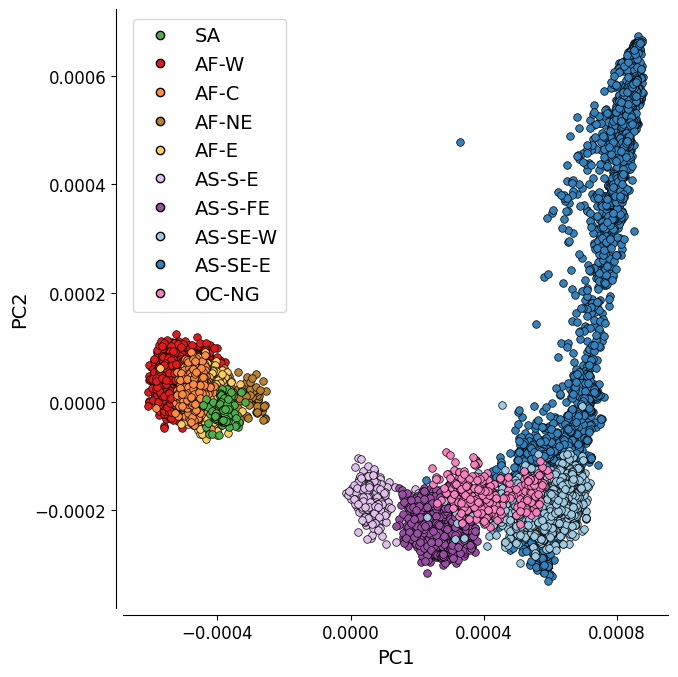

In [20]:
fig = fig_pca(
    pcoa_results,
    'PC1', 'PC2',
    None,
    sample_metadata_qc_pass,
    sample_populations=["AF-W", "AF-NE", "AF-E", "AF-C", "SA",
                        "AS-SE-E", "AS-S-E", "AS-S-FE",
                        "AS-SE-W", "OC-NG"],
    population_column='Population',
    figsize=(7, 7),
    legend_loc="upper left",
    xtick_stepsize=4e-4,
    bbox_to_anchor=None,
    is_randomize=False,
    legend_order=list(colourings["Population"].keys())
)

**Save the figure:**

In [21]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Save PCoA plot
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
file_path = '/content/drive/My Drive/'
file_name = 'Pf7_PCoA_1_vs_2'

# We save as both .png and .PDF files
fig.savefig(f'{file_path}{file_name}.png', dpi=240, bbox_inches="tight")
fig.savefig(f'{file_path}{file_name}.pdf')

## **Figure 1C**: PC1 vs. PC5

This plot shows the first and fifth components of the genome-wide principal coordinate analysis.

While PC5 explains a lower proportion of variation (0.7%) than PC3 or PC4, this plot was chosen for the Pf7 paper as it depicts an approximate mapping between the principal components and the geographic location of samples (latitude and longitude).

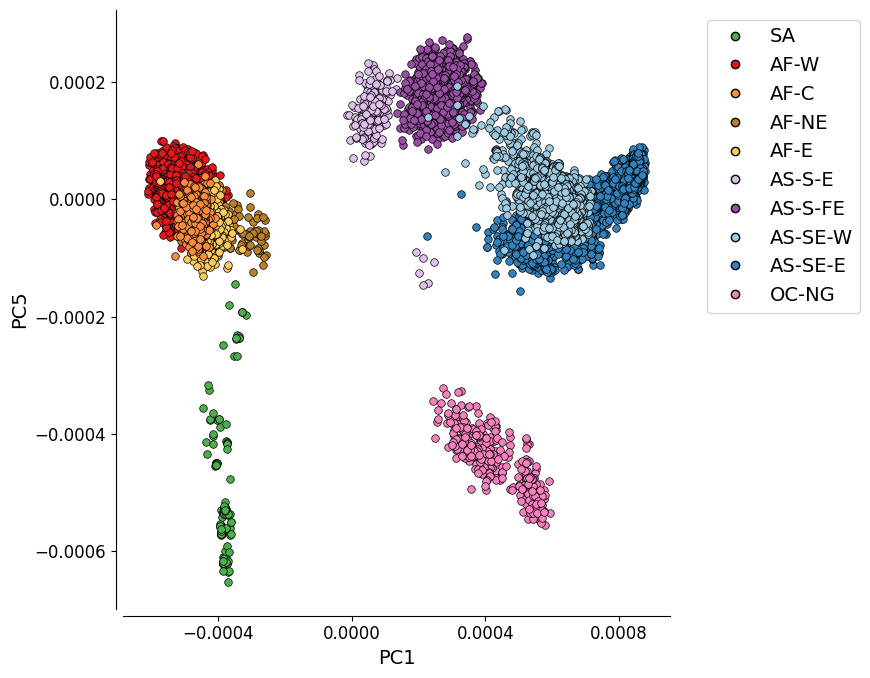

In [23]:
fig = fig_pca(
    pcoa_results,
    'PC1', 'PC5',
    None,
    sample_metadata_qc_pass,
    sample_populations=["AF-W", "AF-NE", "AF-E", "AF-C", "SA",
                        "AS-SE-E", "AS-S-E", "AS-S-FE",
                        "AS-SE-W", "OC-NG"],
    population_column='Population',
    figsize=(9, 7),
    legend_loc="upper left",
    xtick_stepsize=4e-4,
    bbox_to_anchor=(1.05, 1),
    legend_order=list(colourings["Population"].keys()),
    include_prop_explain=False
)

**Save the figure:**

In [24]:
# Save PCoA plot
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
file_path = '/content/drive/My Drive/'
file_name = 'Pf7_PCoA_1_vs_5'

# We save as both .png and .PDF files
fig.savefig(f'{file_path}{file_name}.png', dpi=240, bbox_inches="tight")
fig.savefig(f'{file_path}{file_name}.pdf')

## **Additional Plot 1**: PC1 vs. PC3

For completeness, we can also look at the PCoA when the PCs which explain most variation are plotted. Here we see PC1 vs PC3.

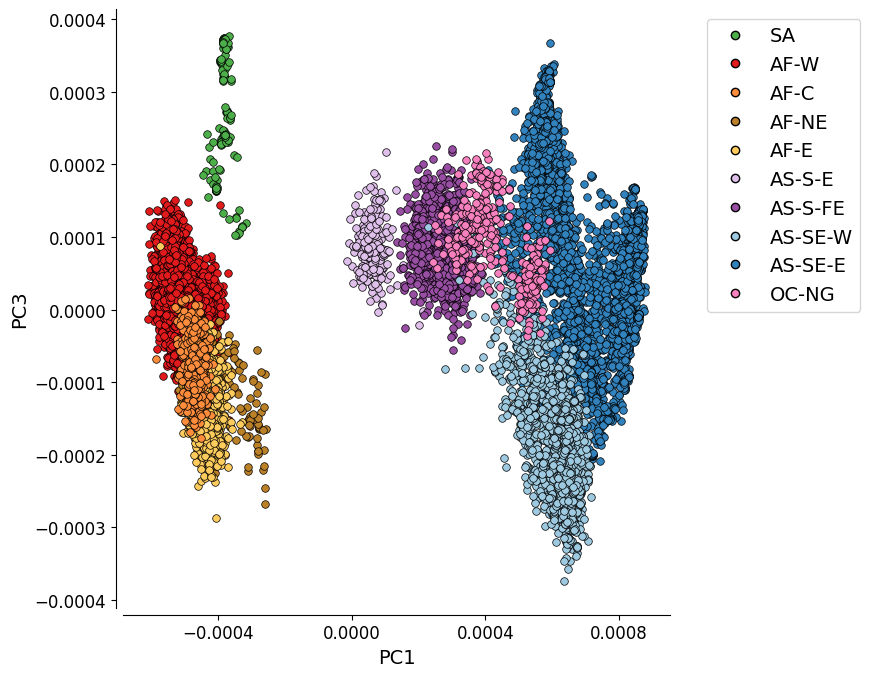

In [25]:
fig = fig_pca(
    pcoa_results,
    'PC1', 'PC3',
    None,
    sample_metadata_qc_pass,
    sample_populations=["AF-W", "AF-NE", "AF-E", "AF-C", "SA",
                        "AS-SE-E", "AS-S-E", "AS-S-FE",
                        "AS-SE-W", "OC-NG"],
    population_column='Population',
    figsize=(9, 7),
    legend_loc="upper left",
    xtick_stepsize=4e-4,
    bbox_to_anchor=(1.05, 1),
    legend_order=list(colourings["Population"].keys())
)

**Save the figure:**

In [26]:
# Save PCoA plot
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
file_path = '/content/drive/My Drive/'
file_name = 'Pf7_PCoA_1_vs_3'

# We save as both .png and .PDF files
fig.savefig(f'{file_path}{file_name}.png', dpi=240, bbox_inches="tight")
fig.savefig(f'{file_path}{file_name}.pdf')

## **Additional Plot 2**: PC2 vs. PC3

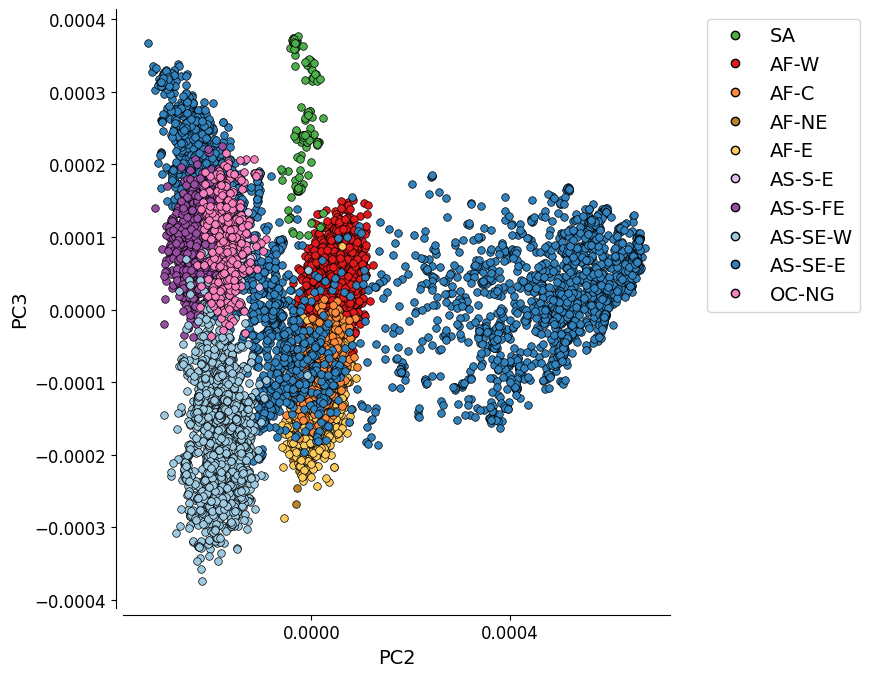

In [27]:
fig = fig_pca(
    pcoa_results,
    'PC2', 'PC3',
    None,
    sample_metadata_qc_pass,
    sample_populations=["AF-W", "AF-NE", "AF-E", "AF-C", "SA",
                        "AS-SE-E", "AS-S-E", "AS-S-FE",
                        "AS-SE-W", "OC-NG"],
    population_column='Population',
    figsize=(9, 7),
    legend_loc="upper left",
    xtick_stepsize=4e-4,
    bbox_to_anchor=(1.05, 1),
    legend_order=list(colourings["Population"].keys())
)

#fig.savefig('figures/Pf7.0_PCoA_2_vs_3.pdf')
#fig.savefig('figures/Pf7.0_PCoA_2_vs_3.png', dpi=600)

**Save the figure:**

In [28]:
# Save PCoA plot
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
file_path = '/content/drive/My Drive/'
file_name = 'Pf7_PCoA_2_vs_3'

# We save as both .png and .PDF files
fig.savefig(f'{file_path}{file_name}.png', dpi=240, bbox_inches="tight")
fig.savefig(f'{file_path}{file_name}.pdf')

## Notebook Complete!

You should now have recreated Figure 1B & 1C, and have two additional plots exploring the first three PCs.